In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
print('all done')

all done


In [3]:
from google.colab import files
uploaded = files.upload()

Saving housing.csv to housing.csv


In [4]:
housing = pd.read_csv('housing.csv')

print(housing.head())
print(housing.info())
print(housing.describe())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [5]:
housing.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [6]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace = True)

/tmp/ipython-input-3501924493.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['total_bedrooms'].fillna(median, inplace = True)


In [7]:
duplicates = housing.duplicated().sum()
print('Number of duplicate rows:', duplicates)

housing = housing.drop_duplicates()

print('Dataset shape after cleaning:', housing.shape)

Number of duplicate rows: 0
Dataset shape after cleaning: (20640, 10)


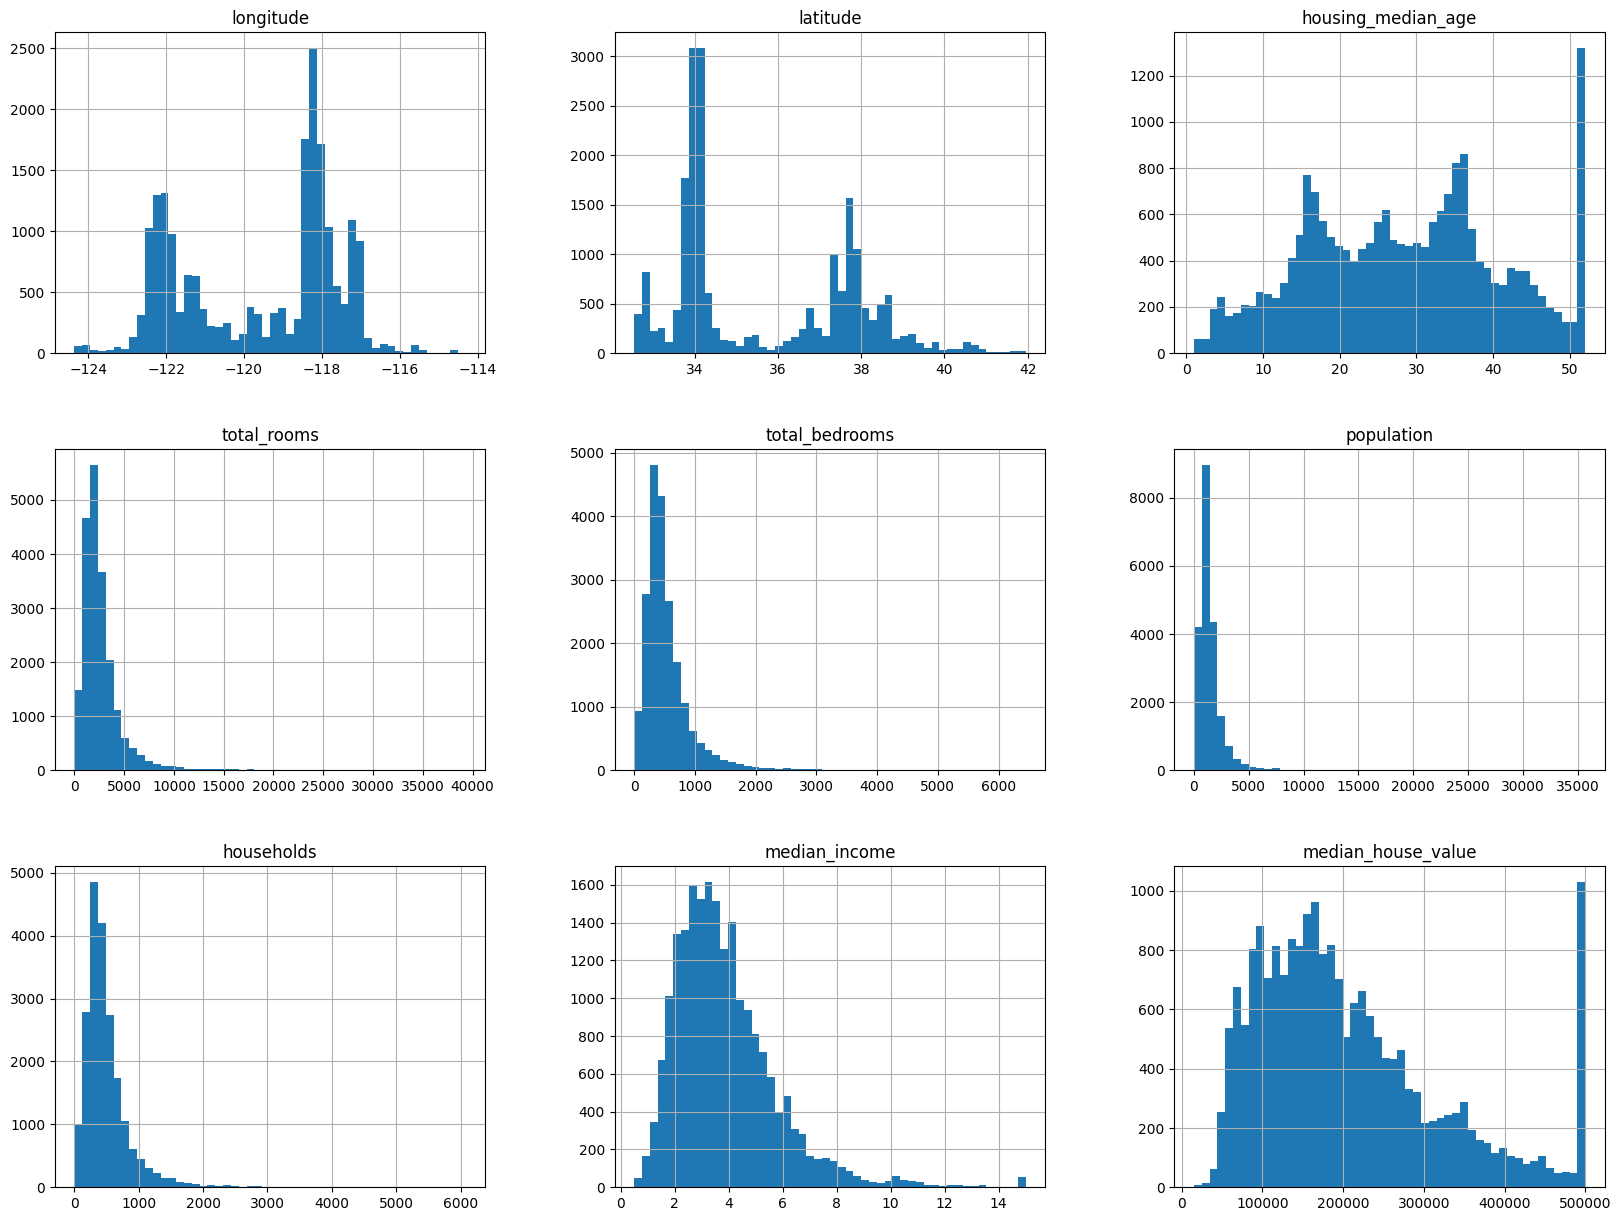

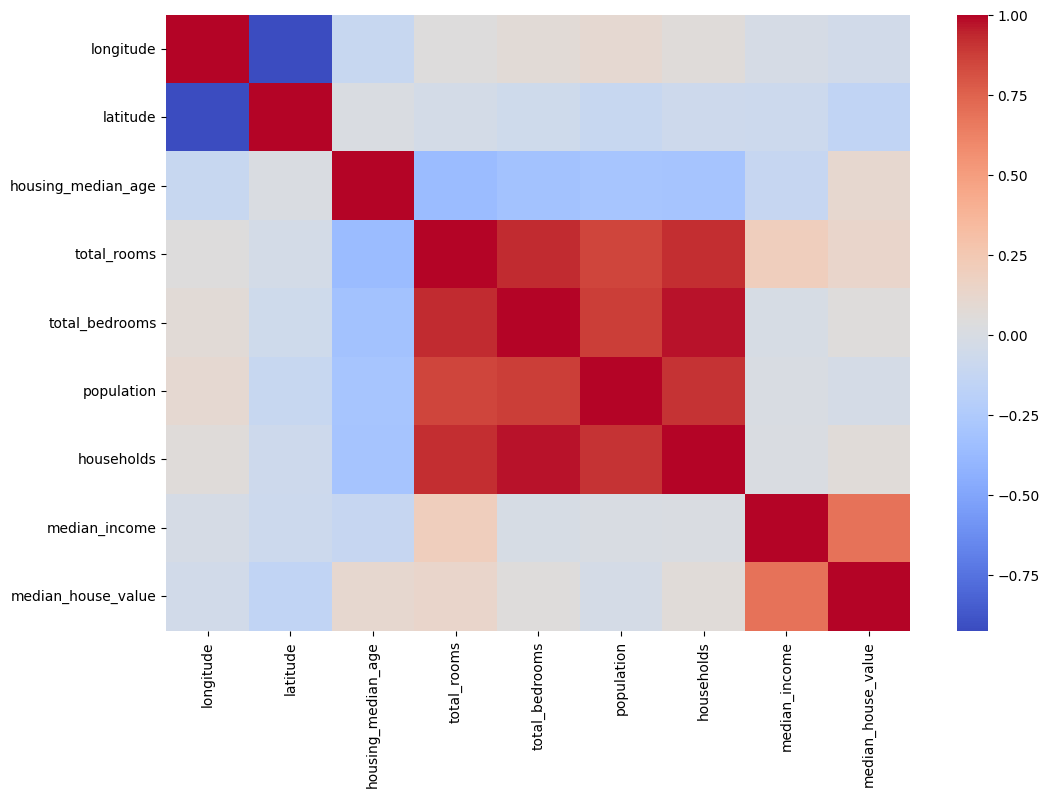

In [8]:
housing.hist(bins = 50, figsize = (20,15))
plt.show()

corr_matrix = housing.corr(numeric_only = True)
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix, annot = False, cmap = 'coolwarm')
plt.show()

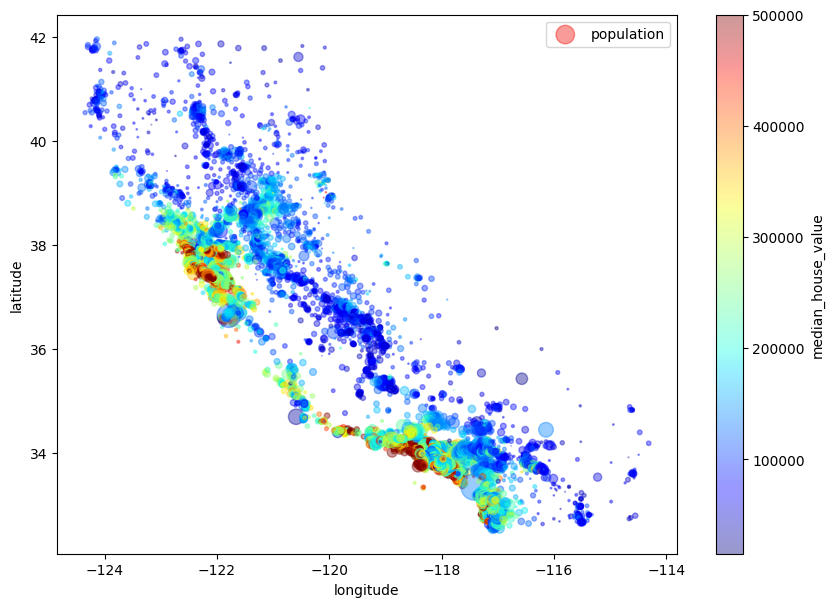

In [9]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
             s = housing['population']/100, label = 'population', figsize = (10,7),
             c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()
plt.show()

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


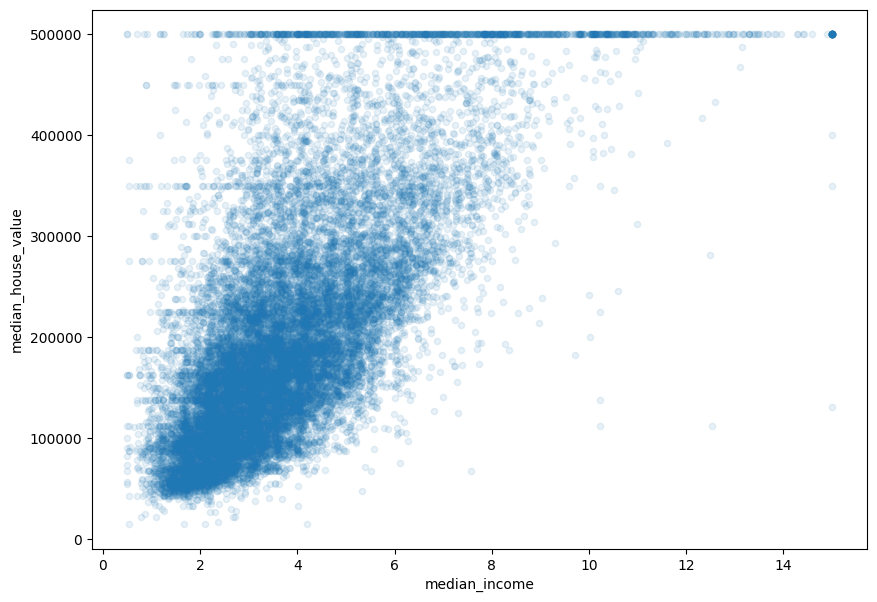

In [10]:
print(corr_matrix['median_house_value'].sort_values(ascending = False))

housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value',
             alpha = 0.1, figsize = (10,7))
plt.show()

In [11]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

housing_train = train_set.copy()
housing_test = test_set.copy()

In [12]:
for dataset in (housing_train, housing_test):
    dataset['rooms_per_household'] = dataset['total_rooms'] / dataset['households']
    dataset['bedrooms_per_room'] = dataset['total_bedrooms'] / dataset['total_rooms']
    dataset['population_per_household'] = dataset['population'] / dataset['households']

In [13]:
X_train = housing_train.drop('median_house_value', axis = 1)
y_train = housing_train['median_house_value'].copy()

X_test = housing_test.drop('median_house_value', axis = 1)
y_test = housing_test['median_house_value'].copy()

In [14]:
num_attribs = X_train.drop('ocean_proximity', axis = 1).columns
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [15]:
results = {}

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
y_pred_lin = lin_reg.predict(X_test_prepared)
results['Linear Regression'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lin)),
    'MAE': mean_absolute_error(y_test, y_pred_lin),
    'R2': r2_score(y_test, y_pred_lin)}

knn_reg = KNeighborsRegressor(n_neighbors = 5)
knn_reg.fit(X_train_prepared, y_train)
y_pred_knn = knn_reg.predict(X_test_prepared)
results['KNN'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_knn)),
    'MAE': mean_absolute_error(y_test, y_pred_knn),
    'R2': r2_score(y_test, y_pred_knn)}

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(X_train_prepared, y_train)
y_pred_tree = tree_reg.predict(X_test_prepared)
results['Decision Tree'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_tree)),
    'MAE': mean_absolute_error(y_test, y_pred_tree),
    'R2': r2_score(y_test, y_pred_tree)}

forest_reg = RandomForestRegressor(random_state = 42)
forest_reg.fit(X_train_prepared, y_train)
y_pred_forest = forest_reg.predict(X_test_prepared)
results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_forest)),
    'MAE': mean_absolute_error(y_test, y_pred_forest),
    'R2': r2_score(y_test, y_pred_forest)}

In [17]:
median_price = housing['median_house_value'].median()
y_train_class = (y_train > median_price).astype(int)
y_test_class = (y_test > median_price).astype(int)

log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train_prepared, y_train_class)
y_pred_log = log_reg.predict(X_test_prepared)

results['Logistic Regression (Class)'] = {
    'Accuracy': accuracy_score(y_test_class, y_pred_log),
    'Precision': precision_score(y_test_class, y_pred_log),
    'Recall': recall_score(y_test_class, y_pred_log),
    'F1': f1_score(y_test_class, y_pred_log)}

In [18]:
print('Model Results')
for model, metrics in results.items():
    print(f'\n{model}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')

Model Results

Linear Regression:
RMSE: 72668.5384
MAE: 50888.6600
R2: 0.5970

KNN:
RMSE: 62344.4518
MAE: 41711.7283
R2: 0.7034

Decision Tree:
RMSE: 71818.7641
MAE: 43888.4138
R2: 0.6064

Random Forest:
RMSE: 50363.6034
MAE: 32339.0973
R2: 0.8064

Logistic Regression (Class):
Accuracy: 0.8370
Precision: 0.8338
Recall: 0.8391
F1: 0.8365
